In [1]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
merged_df_inner = pd.read_excel('merged_df_inner.xlsx', engine='openpyxl')

In [3]:
merged_df_inner.columns.tolist()

['Load',
 'Stop',
 'Driver Region',
 'Driver ID',
 'Driver',
 'Company ID',
 'Company',
 'Address',
 'City',
 'State',
 'Routing Region',
 'Miles From Prev Stop',
 'Weight',
 'Cube',
 'Piece Cnt',
 'Lines',
 'Planned Time',
 'Print Of DR',
 'Load Due Out',
 'DC Departure',
 'Appt',
 'GPS Arrival',
 'GPS Departure',
 'Time Diff',
 'Per',
 'STC',
 'FCFS',
 'Start Time',
 'Dock Time',
 'Dock Time Converted',
 'Appt Week',
 'Trailer Space Utilization',
 'Appt Day',
 'DepartBeforeAppt',
 'GPSERROR',
 'LATE',
 'Skipped',
 'Trailer Type',
 'Dry Piece Count',
 'Refrig Piece Count',
 'Frozen Piece Count',
 'Frt Set Temp',
 'Frt Actual Temp',
 'Mid Set Temp',
 'Mid Actual Temp',
 'Rear Set Temp',
 'Rear Actual Temp']

In [4]:
import pandas as pd
import numpy as np

# 假设 merged_df_inner 是你的 DataFrame
# 首先按 Load 和 Piece Cnt 降序排列
merged_df_inner['Load'] = merged_df_inner['Load'].astype(str)
merged_df_inner = merged_df_inner.sort_values(by=['Load', 'Piece Cnt'], ascending=[True, False])

# 对每个 Load 进行分组
for load, group in merged_df_inner.groupby('Load'):
    # 获取当前 Load 下的最大 Piece Cnt 及其对应的 Dry, Refrig, Frozen Piece Count
    max_piece_cnt = group.iloc[0]['Piece Cnt']
    max_dry_piece_count = group.iloc[0]['Dry Piece Count']
    max_refrig_piece_count = group.iloc[0]['Refrig Piece Count']
    max_frozen_piece_count = group.iloc[0]['Frozen Piece Count']
    
    # 检查是否有 NaN 值
    if pd.isna(max_piece_cnt) or pd.isna(max_dry_piece_count) or pd.isna(max_refrig_piece_count) or pd.isna(max_frozen_piece_count):
        continue  # 如果最大值中有 NaN，跳过该组

    # 遍历当前 Load 下的所有行，按最大值比例调整
    for index, row in group.iterrows():
        # 计算比例调整后的 Piece Counts，确保处理 NaN 值
        if not pd.isna(row['Piece Cnt']) and row['Piece Cnt'] > 0:
            adjusted_dry = (row['Piece Cnt'] / max_piece_cnt) * max_dry_piece_count
            adjusted_refrig = (row['Piece Cnt'] / max_piece_cnt) * max_refrig_piece_count
            adjusted_frozen = (row['Piece Cnt'] / max_piece_cnt) * max_frozen_piece_count

            # 更新调整后的值到 DataFrame，并取整
            merged_df_inner.at[index, 'Adjusted Dry Piece Count'] = round(adjusted_dry)
            merged_df_inner.at[index, 'Adjusted Refrig Piece Count'] = round(adjusted_refrig)
            merged_df_inner.at[index, 'Adjusted Frozen Piece Count'] = round(adjusted_frozen)
        else:
            # 如果 Piece Cnt 为 NaN 或 0，直接跳过
            merged_df_inner.at[index, 'Adjusted Dry Piece Count'] = np.nan
            merged_df_inner.at[index, 'Adjusted Refrig Piece Count'] = np.nan
            merged_df_inner.at[index, 'Adjusted Frozen Piece Count'] = np.nan

# 查看 Load 为 239168692 的结果
filtered_df = merged_df_inner[merged_df_inner['Load'] == '239168692']
print(filtered_df[['Load', 'Piece Cnt', 'Dry Piece Count', 'Refrig Piece Count', 'Frozen Piece Count', 
                  'Adjusted Dry Piece Count', 'Adjusted Refrig Piece Count', 'Adjusted Frozen Piece Count']])

            Load  Piece Cnt  Dry Piece Count  Refrig Piece Count  \
38340  239168692       1180              576                 215   
38342  239168692        468              576                 215   
38341  239168692         70              576                 215   

       Frozen Piece Count  Adjusted Dry Piece Count  \
38340                 459                     576.0   
38342                 459                     228.0   
38341                 459                      34.0   

       Adjusted Refrig Piece Count  Adjusted Frozen Piece Count  
38340                        215.0                        459.0  
38342                         85.0                        182.0  
38341                         13.0                         27.0  


In [5]:
#做 anova test
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 假设你已经加载了数据集
# merged_df_inner = pd.read_csv('your_file.csv')  # 替换为你的文件路径

# 选择相关列
df = merged_df_inner[['Driver Region',  'Driver',  'Company', 'Address', 'City', 'Routing Region', 'Dock Time Converted']]

# 将分类变量转换为字符串类型
categorical_columns = ['Driver Region',  'Driver',  'Company', 'Address', 'City', 'Routing Region']
df[categorical_columns] = df[categorical_columns].astype(str)

# 定义一个函数对单个变量进行ANOVA测试
def perform_anova(column_name):
    formula = f'Q("Dock Time Converted") ~ Q("{column_name}")'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {column_name}:")
    print(anova_table[['F', 'PR(>F)']])
    print("\n")

# 依次对每个变量执行ANOVA
for col in categorical_columns:
    perform_anova(col)


C:\Users\YuxuanLiu\AppData\Local\Temp\ipykernel_40740\1237645565.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_columns] = df[categorical_columns].astype(str)


ANOVA results for Driver Region:
                            F         PR(>F)
Q("Driver Region")  45.304369  2.934174e-178
Residual                  NaN            NaN


ANOVA results for Driver:
                    F  PR(>F)
Q("Driver")  4.905554     0.0
Residual          NaN     NaN


ANOVA results for Company:
                      F  PR(>F)
Q("Company")  16.145481     0.0
Residual            NaN     NaN


ANOVA results for Address:
                     F  PR(>F)
Q("Address")  16.85368     0.0
Residual           NaN     NaN


ANOVA results for City:
                   F  PR(>F)
Q("City")  21.518489     0.0
Residual         NaN     NaN


ANOVA results for Routing Region:
                             F         PR(>F)
Q("Routing Region")  47.001502  1.501668e-203
Residual                   NaN            NaN




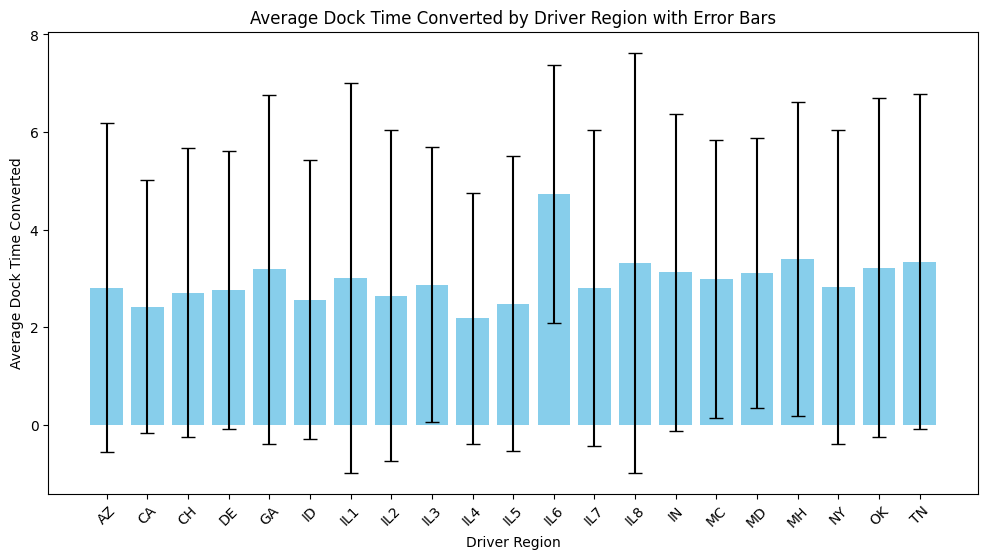

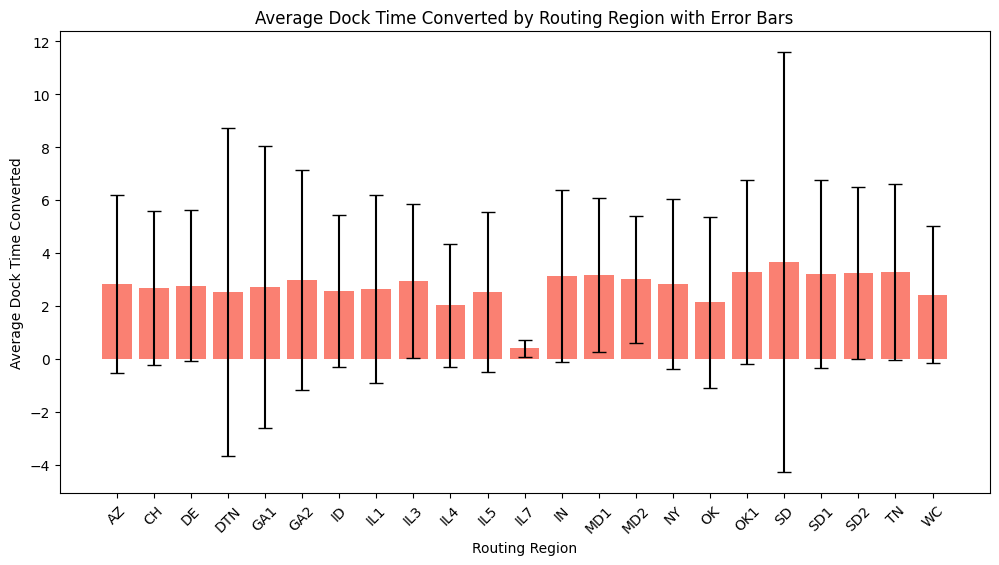

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 merged_df_inner 是你的数据集

# 计算 'Dock Time Converted' 按 'Driver Region' 的均值和标准差
driver_region_stats = merged_df_inner.groupby('Driver Region')['Dock Time Converted'].agg(['mean', 'std'])

# 绘制 'Driver Region' 的柱状图并添加误差棒
plt.figure(figsize=(12, 6))
plt.bar(driver_region_stats.index, driver_region_stats['mean'], yerr=driver_region_stats['std'], capsize=5, color='skyblue')
plt.title('Average Dock Time Converted by Driver Region with Error Bars')
plt.xlabel('Driver Region')
plt.ylabel('Average Dock Time Converted')
plt.xticks(rotation=45)
plt.show()

# 计算 'Dock Time Converted' 按 'Routing Region' 的均值和标准差
routing_region_stats = merged_df_inner.groupby('Routing Region')['Dock Time Converted'].agg(['mean', 'std'])

# 绘制 'Routing Region' 的柱状图并添加误差棒
plt.figure(figsize=(12, 6))
plt.bar(routing_region_stats.index, routing_region_stats['mean'], yerr=routing_region_stats['std'], capsize=5, color='salmon')
plt.title('Average Dock Time Converted by Routing Region with Error Bars')
plt.xlabel('Routing Region')
plt.ylabel('Average Dock Time Converted')
plt.xticks(rotation=45)
plt.show()


C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


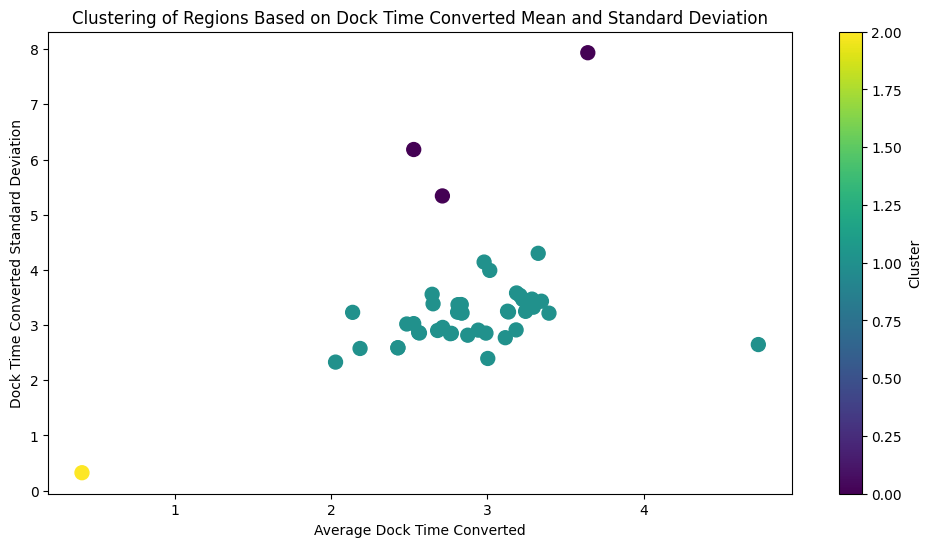

       Region Type Region      mean       std  Cluster
0    Driver Region     AZ  2.811287  3.370774        1
1    Driver Region     CA  2.425972  2.589357        1
2    Driver Region     CH  2.713052  2.958329        1
3    Driver Region     DE  2.768686  2.851093        1
4    Driver Region     GA  3.186089  3.582490        1
5    Driver Region     ID  2.564348  2.856839        1
6    Driver Region    IL1  3.014516  3.991392        1
7    Driver Region    IL2  2.651523  3.386397        1
8    Driver Region    IL3  2.873650  2.817212        1
9    Driver Region    IL4  2.184066  2.576847        1
10   Driver Region    IL5  2.483119  3.020201        1
11   Driver Region    IL6  4.734130  2.647749        1
12   Driver Region    IL7  2.808639  3.234400        1
13   Driver Region    IL8  3.324678  4.300837        1
14   Driver Region     IN  3.128452  3.251900        1
15   Driver Region     MC  2.990218  2.855048        1
16   Driver Region     MD  3.114005  2.772075        1
17   Drive

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# 计算 'Driver Region' 和 'Routing Region' 的均值和标准差
driver_region_stats = merged_df_inner.groupby('Driver Region')['Dock Time Converted'].agg(['mean', 'std']).fillna(0)
routing_region_stats = merged_df_inner.groupby('Routing Region')['Dock Time Converted'].agg(['mean', 'std']).fillna(0)

# 合并数据用于聚类
region_stats = pd.concat([driver_region_stats, routing_region_stats], keys=['Driver Region', 'Routing Region']).reset_index()
X = region_stats[['mean', 'std']]

# KMeans 聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
region_stats['Cluster'] = kmeans.labels_

# 绘制聚类结果
plt.figure(figsize=(12, 6))
plt.scatter(region_stats['mean'], region_stats['std'], c=region_stats['Cluster'], cmap='viridis', s=100)
plt.xlabel('Average Dock Time Converted')
plt.ylabel('Dock Time Converted Standard Deviation')
plt.title('Clustering of Regions Based on Dock Time Converted Mean and Standard Deviation')
plt.colorbar(label='Cluster')
plt.show()

# 查看聚类结果
print(region_stats[['level_0', 'level_1', 'mean', 'std', 'Cluster']].rename(columns={'level_0': 'Region Type', 'level_1': 'Region'}))


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_cleaned is your DataFrame containing 'State', 'Dock Time Converted', and 'Piece Count' columns

# Define the states in each region
northeastern_states = ['NY', 'NJ', 'CT', 'MA', 'PA', 'VT', 'NH', 'ME', 'RI']
western_states = ['CA', 'OR', 'WA', 'NV', 'AZ', 'CO', 'UT', 'ID', 'MT', 'WY']
southern_states = ['TX', 'FL', 'GA', 'SC', 'NC', 'AL', 'MS', 'LA', 'AR', 'OK']
midwestern_states = ['IL', 'IN', 'OH', 'MI', 'WI', 'IA', 'MO', 'MN', 'KS', 'NE']

# Create a function to map each state to a region
def get_region(state):
    if state in northeastern_states:
        return 'Northeast'
    elif state in western_states:
        return 'West'
    elif state in southern_states:
        return 'South'
    elif state in midwestern_states:
        return 'Midwest'
    else:
        return 'Other'

# Apply the function to create a new 'Region' column in your DataFrame
merged_df_inner['Region'] = merged_df_inner['State'].apply(get_region)

# Calculate total dock time and total piece count per state
state_docktime_piece_count = merged_df_inner.groupby('State').agg({
    'Dock Time Converted': 'sum',
    'Piece Cnt': 'sum'
}).reset_index()

# Calculate dock time per piece count for each state
state_docktime_piece_count['Dock Time Per Piece'] = state_docktime_piece_count['Dock Time Converted'] / state_docktime_piece_count['Piece Cnt']

# Map each state to its region for the aggregated data
state_docktime_piece_count['Region'] = state_docktime_piece_count['State'].apply(get_region)

# Calculate mean dock time per piece count by region and sort in descending order
region_docktime_per_piece = state_docktime_piece_count.groupby('Region')['Dock Time Per Piece'].mean().reset_index()
region_docktime_per_piece = region_docktime_per_piece.sort_values(by='Dock Time Per Piece', ascending=False)

In [9]:
state_docktime_piece_count

,State,Dock Time Converted,Piece Cnt,Dock Time Per Piece,Region
0,AL,7744.889853,3579799,0.002163,South
1,AR,2095.496634,1339805,0.001564,South
2,AZ,3950.425721,2026205,0.001950,West
3,CA,26485.058516,13086284,0.002024,West
4,CO,4919.563535,2613296,0.001883,West
5,CT,3758.685819,1555699,0.002416,Northeast
6,DC,22.322941,31644,0.000705,Other
7,DE,125.030501,98259,0.001272,Other
8,FL,18384.755376,7168039,0.002565,South
9,GA,12019.144683,5702250,0.002108,South


In [10]:
from sklearn.cluster import KMeans
import pandas as pd

# 假设 merged_df_inner 是你的数据集

# 计算每个类别的 'Dock Time Converted' 平均值
driver_means = merged_df_inner.groupby('Driver')['Dock Time Converted'].mean()
company_means = merged_df_inner.groupby('Company')['Dock Time Converted'].mean()
address_means = merged_df_inner.groupby('Address')['Dock Time Converted'].mean()
city_means = merged_df_inner.groupby('City')['Dock Time Converted'].mean()
routing_region_means = merged_df_inner.groupby('Routing Region')['Dock Time Converted'].mean()
driver_region_means = merged_df_inner.groupby('Driver Region')['Dock Time Converted'].mean()
region_means = merged_df_inner.groupby('Region')['Dock Time Converted'].mean()
# 设置 K-means 聚类的类数，比如 3 类（高、中、低）
n_clusters = 3

# 对每个变量的均值进行聚类
driver_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(driver_means.values.reshape(-1, 1))
company_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(company_means.values.reshape(-1, 1))
address_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(address_means.values.reshape(-1, 1))
city_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(city_means.values.reshape(-1, 1))
routing_region_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(routing_region_means.values.reshape(-1, 1))
driver_region_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(driver_region_means.values.reshape(-1, 1))
region_clusters = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(region_means.values.reshape(-1, 1))
# 将聚类结果映射回原始数据
merged_df_inner['Driver_Cluster'] = merged_df_inner['Driver'].map(dict(zip(driver_means.index, driver_clusters)))
merged_df_inner['Company_Cluster'] = merged_df_inner['Company'].map(dict(zip(company_means.index, company_clusters)))
merged_df_inner['Address_Cluster'] = merged_df_inner['Address'].map(dict(zip(address_means.index, address_clusters)))
merged_df_inner['City_Cluster'] = merged_df_inner['City'].map(dict(zip(city_means.index, city_clusters)))
merged_df_inner['routing_region_clusters'] = merged_df_inner['Routing Region'].map(dict(zip(routing_region_means.index, city_clusters)))
merged_df_inner['Driver_Region_clusters'] = merged_df_inner['Driver Region'].map(dict(zip(driver_region_means.index, city_clusters)))
merged_df_inner['region_clusters'] = merged_df_inner['Region'].map(dict(zip(region_means.index, city_clusters)))
# 查看结果
print(merged_df_inner[['Driver', 'Driver_Cluster', 'Company', 'Company_Cluster', 'Address', 'Address_Cluster', 'City', 'City_Cluster']].head())


C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\YuxuanLiu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

               Driver  Driver_Cluster                   Company  \
38340     MARKMAZZOLA               0           HPC FOODSERVICE   
38342     MARKMAZZOLA               0      STOP&SHOP/MANCHESTER   
38341     MARKMAZZOLA               0  RESTAURANT EQUIPMENT PAR   
412     CHARLESTHOMAS               0      WALGREENS/MT. VERNON   
106    MARCUSROBINSON               2           USF/PORT ORANGE   

       Company_Cluster                              Address  Address_Cluster  \
38340                1  625 NUTMEG RD N                                    0   
38342                0  1315 TOLLAND TURNPIKE                              0   
38341                1  465 PARK AVENUE                                    1   
412                  1  5100 LAKE TERRACE NE                               1   
106                  0  5425 S WILLIAMSON BLVD                             0   

                City  City_Cluster  
38340  South Windsor             1  
38342     Manchester             0  
38341

In [11]:
merged_df_inner.columns

Index(['Load', 'Stop', 'Driver Region', 'Driver ID', 'Driver', 'Company ID',
       'Company', 'Address', 'City', 'State', 'Routing Region',
       'Miles From Prev Stop', 'Weight', 'Cube', 'Piece Cnt', 'Lines',
       'Planned Time', 'Print Of DR', 'Load Due Out', 'DC Departure', 'Appt',
       'GPS Arrival', 'GPS Departure', 'Time Diff', 'Per', 'STC', 'FCFS',
       'Start Time', 'Dock Time', 'Dock Time Converted', 'Appt Week',
       'Trailer Space Utilization', 'Appt Day', 'DepartBeforeAppt', 'GPSERROR',
       'LATE', 'Skipped', 'Trailer Type', 'Dry Piece Count',
       'Refrig Piece Count', 'Frozen Piece Count', 'Frt Set Temp',
       'Frt Actual Temp', 'Mid Set Temp', 'Mid Actual Temp', 'Rear Set Temp',
       'Rear Actual Temp', 'Adjusted Dry Piece Count',
       'Adjusted Refrig Piece Count', 'Adjusted Frozen Piece Count', 'Region',
       'Driver_Cluster', 'Company_Cluster', 'Address_Cluster', 'City_Cluster',
       'routing_region_clusters', 'Driver_Region_clusters', 'region

In [12]:
#one-hot encoding
merged_df_inner_2 = pd.get_dummies(merged_df_inner, columns=['Driver_Region_clusters','region_clusters','Driver_Cluster','City_Cluster','Company_Cluster','Address_Cluster','Trailer Type','Appt Day','State'], dummy_na=True, drop_first=True)

In [13]:
merged_df_inner_2.columns

Index(['Load', 'Stop', 'Driver Region', 'Driver ID', 'Driver', 'Company ID',
       'Company', 'Address', 'City', 'Routing Region',
       ...
       'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA',
       'State_WI', 'State_WV', 'State_WY', 'State_nan'],
      dtype='object', length=126)

In [14]:
merged_df_inner_2.columns.tolist()

['Load',
 'Stop',
 'Driver Region',
 'Driver ID',
 'Driver',
 'Company ID',
 'Company',
 'Address',
 'City',
 'Routing Region',
 'Miles From Prev Stop',
 'Weight',
 'Cube',
 'Piece Cnt',
 'Lines',
 'Planned Time',
 'Print Of DR',
 'Load Due Out',
 'DC Departure',
 'Appt',
 'GPS Arrival',
 'GPS Departure',
 'Time Diff',
 'Per',
 'STC',
 'FCFS',
 'Start Time',
 'Dock Time',
 'Dock Time Converted',
 'Appt Week',
 'Trailer Space Utilization',
 'DepartBeforeAppt',
 'GPSERROR',
 'LATE',
 'Skipped',
 'Dry Piece Count',
 'Refrig Piece Count',
 'Frozen Piece Count',
 'Frt Set Temp',
 'Frt Actual Temp',
 'Mid Set Temp',
 'Mid Actual Temp',
 'Rear Set Temp',
 'Rear Actual Temp',
 'Adjusted Dry Piece Count',
 'Adjusted Refrig Piece Count',
 'Adjusted Frozen Piece Count',
 'Region',
 'routing_region_clusters',
 'Driver_Region_clusters_1.0',
 'Driver_Region_clusters_nan',
 'region_clusters_1.0',
 'region_clusters_nan',
 'Driver_Cluster_1.0',
 'Driver_Cluster_2.0',
 'Driver_Cluster_nan',
 'City_Clust

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


In [16]:
columns_to_drop = ['Load', 'Planned Time', 'Print Of DR', 'Load Due Out', 'Driver ID','Company ID',
                   'DC Departure', 'GPS Arrival', 'GPS Departure', 'Per', 'STC','Cube','Trailer Space Utilization',
                   'FCFS', 'Start Time', 'Dock Time','Dry Piece Count', 'Refrig Piece Count', 'Frozen Piece Count','Miles From Prev Stop',
                   'Appt Week', 'DepartBeforeAppt', 'GPSERROR', 'LATE', 'Skipped','Appt','Frt Set Temp', 'Frt Actual Temp', 'Mid Set Temp', 'Mid Actual Temp', 'Rear Set Temp', 'Rear Actual Temp',]
# 从 DataFrame 中删除未选择的列
merged_df_inner_3 = merged_df_inner_2.drop(columns=columns_to_drop)

In [17]:
merged_df_inner_3.columns

Index(['Stop', 'Driver Region', 'Driver', 'Company', 'Address', 'City',
       'Routing Region', 'Weight', 'Piece Cnt', 'Lines', 'Time Diff',
       'Dock Time Converted', 'Adjusted Dry Piece Count',
       'Adjusted Refrig Piece Count', 'Adjusted Frozen Piece Count', 'Region',
       'routing_region_clusters', 'Driver_Region_clusters_1.0',
       'Driver_Region_clusters_nan', 'region_clusters_1.0',
       'region_clusters_nan', 'Driver_Cluster_1.0', 'Driver_Cluster_2.0',
       'Driver_Cluster_nan', 'City_Cluster_1.0', 'City_Cluster_2.0',
       'City_Cluster_nan', 'Company_Cluster_1.0', 'Company_Cluster_2.0',
       'Company_Cluster_nan', 'Address_Cluster_1.0', 'Address_Cluster_2.0',
       'Address_Cluster_nan', 'Trailer Type_EMPTY', 'Trailer Type_FROZEN',
       'Trailer Type_MIXED', 'Trailer Type_REF', 'Trailer Type_nan',
       'Appt Day_Mon', 'Appt Day_Sat', 'Appt Day_Sun', 'Appt Day_Thu',
       'Appt Day_Tue', 'Appt Day_Wed', 'Appt Day_nan', 'State_AR', 'State_AZ',
       'Sta

In [18]:
#regression 当中没法存在缺失值 先对缺失值进行处理
# 检查每一列的缺失值数量
missing_values = merged_df_inner_3.isna().sum()

# 仅显示包含缺失值的列
missing_values = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
print(missing_values)


Columns with missing values and their counts:
Adjusted Dry Piece Count       186
Adjusted Refrig Piece Count    186
Adjusted Frozen Piece Count    186
dtype: int64


In [19]:
# 删除包含 NaN 的行
merged_df_inner_3 = merged_df_inner_3.dropna()

In [20]:
merged_df_inner_3.columns

Index(['Stop', 'Driver Region', 'Driver', 'Company', 'Address', 'City',
       'Routing Region', 'Weight', 'Piece Cnt', 'Lines', 'Time Diff',
       'Dock Time Converted', 'Adjusted Dry Piece Count',
       'Adjusted Refrig Piece Count', 'Adjusted Frozen Piece Count', 'Region',
       'routing_region_clusters', 'Driver_Region_clusters_1.0',
       'Driver_Region_clusters_nan', 'region_clusters_1.0',
       'region_clusters_nan', 'Driver_Cluster_1.0', 'Driver_Cluster_2.0',
       'Driver_Cluster_nan', 'City_Cluster_1.0', 'City_Cluster_2.0',
       'City_Cluster_nan', 'Company_Cluster_1.0', 'Company_Cluster_2.0',
       'Company_Cluster_nan', 'Address_Cluster_1.0', 'Address_Cluster_2.0',
       'Address_Cluster_nan', 'Trailer Type_EMPTY', 'Trailer Type_FROZEN',
       'Trailer Type_MIXED', 'Trailer Type_REF', 'Trailer Type_nan',
       'Appt Day_Mon', 'Appt Day_Sat', 'Appt Day_Sun', 'Appt Day_Thu',
       'Appt Day_Tue', 'Appt Day_Wed', 'Appt Day_nan', 'State_AR', 'State_AZ',
       'Sta

In [21]:
X.info


<bound method DataFrame.info of         mean       std
0   2.811287  3.370774
1   2.425972  2.589357
2   2.713052  2.958329
3   2.768686  2.851093
4   3.186089  3.582490
5   2.564348  2.856839
6   3.014516  3.991392
7   2.651523  3.386397
8   2.873650  2.817212
9   2.184066  2.576847
10  2.483119  3.020201
11  4.734130  2.647749
12  2.808639  3.234400
13  3.324678  4.300837
14  3.128452  3.251900
15  2.990218  2.855048
16  3.114005  2.772075
17  3.393681  3.216724
18  2.832545  3.220192
19  3.225589  3.465183
20  3.345434  3.433128
21  2.832041  3.372699
22  2.680727  2.902643
23  2.762026  2.844780
24  2.527685  6.181956
25  2.711259  5.340675
26  2.978408  4.142407
27  2.558997  2.866306
28  2.645649  3.558449
29  2.940696  2.909134
30  2.027240  2.329850
31  2.527521  3.027156
32  0.403601  0.325453
33  3.134551  3.237968
34  3.183237  2.913192
35  3.001843  2.395751
36  2.837342  3.219763
37  2.136475  3.231144
38  3.284831  3.470892
39  3.642287  7.935558
40  3.207956  3.538026
41

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Step 1: Separate features (X) and target (y)
X = merged_df_inner_3.drop(columns=['Dock Time Converted','Routing Region','Driver Region','Driver','Company', 'Address', 'City','Region'])  # Features
y = merged_df_inner_3['Dock Time Converted']  # Target

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]  # Number of samples in the test set
    p = X_test.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f"{model.__class__.__name__} - RMSE: {rmse:.2f}, R²: {r2:.2f}, Adjusted R²: {adjusted_r2:.2f}")
    return rmse, r2, adjusted_r2

# Step 3: Initialize models


linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linear_model.fit(X_train_scaled, y_train)
evaluate_model(linear_model, X_test_scaled, y_test)

random_forest_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=84
)
random_forest_model.fit(X_train, y_train)
evaluate_model(random_forest_model, X_test, y_test)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test)
         # XGBoost
         # XGBoost


LinearRegression - RMSE: 2.64, R²: 0.31, Adjusted R²: 0.31
RandomForestRegressor - RMSE: 2.27, R²: 0.49, Adjusted R²: 0.49
XGBRegressor - RMSE: 2.25, R²: 0.50, Adjusted R²: 0.50


(2.253200905926455, 0.49865392866545566, 0.49644263714146497)

   Top 10 Features by Random Forest Importance:
                        Feature  RF_Importance
19          Company_Cluster_1.0       0.319062
4                     Time Diff       0.193999
2                     Piece Cnt       0.106439
3                         Lines       0.059339
1                        Weight       0.057201
5      Adjusted Dry Piece Count       0.049612
7   Adjusted Frozen Piece Count       0.037984
6   Adjusted Refrig Piece Count       0.034180
14           Driver_Cluster_2.0       0.013702
22          Address_Cluster_1.0       0.012913
   Top 10 Features by Linear Regression Coefficients:
                Feature  Linear_Coefficient
18     City_Cluster_nan        2.382596e+12
29     Trailer Type_nan        2.172414e+12
36         Appt Day_nan        1.597146e+12
24  Address_Cluster_nan        1.121465e+12
11  region_clusters_1.0        1.491698e+11
2             Piece Cnt        3.874374e-01
14   Driver_Cluster_2.0        2.908499e-01
1                Weight      

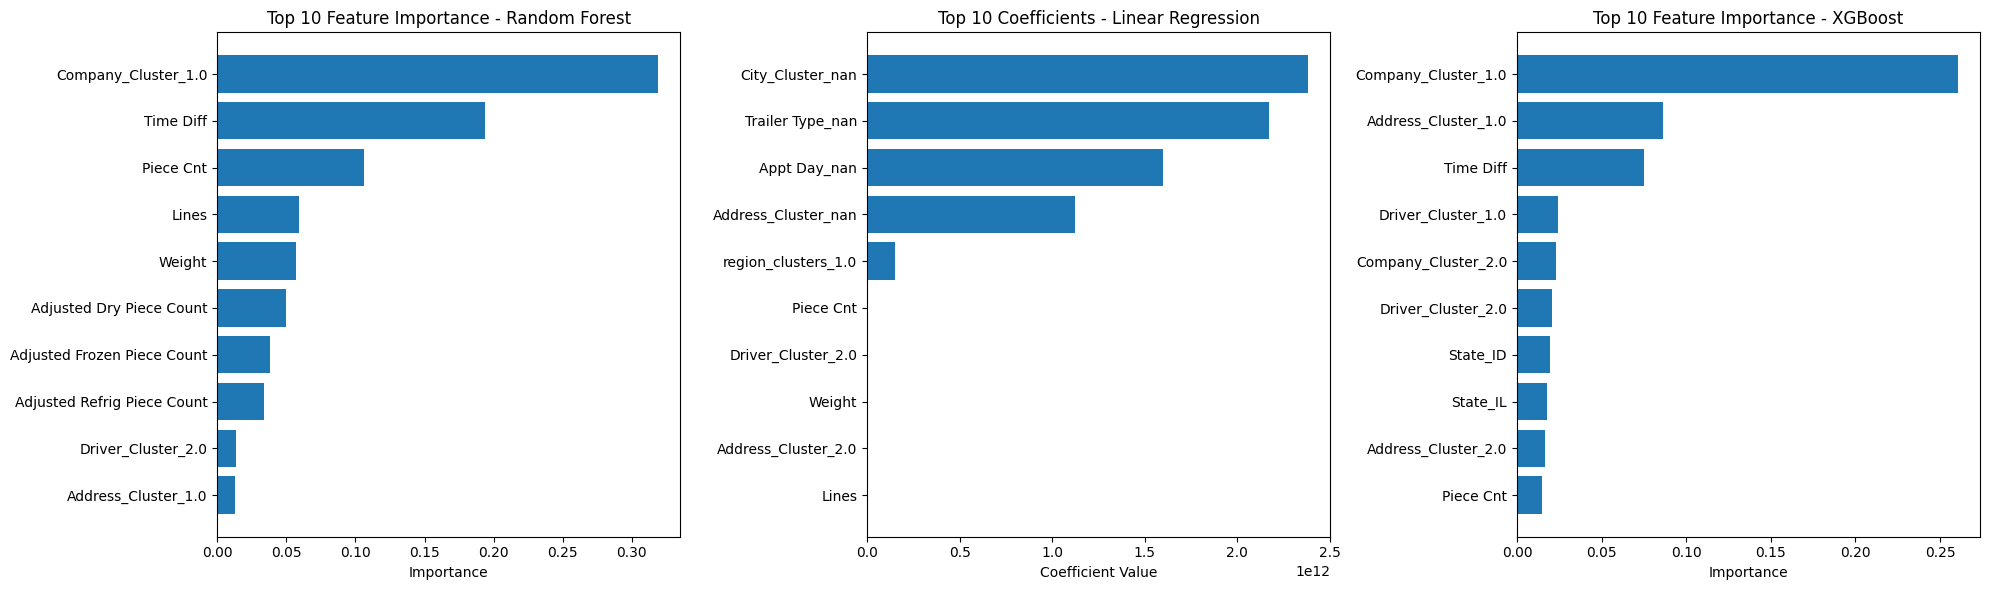

In [31]:
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': random_forest_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False).head(10)

# Linear Regression Coefficients
linear_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Linear_Coefficient': linear_model.coef_
}).sort_values(by='Linear_Coefficient', ascending=False).head(10)

# XGB Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values(by='XGB_Importance', ascending=False).head(10)

# Display the top 10 features for each model
print("   Top 10 Features by Random Forest Importance:")
print(rf_importance)
print("   Top 10 Features by Linear Regression Coefficients:")
print(linear_coefficients)
print("   Top 10 Features by XGB Importance:")
print(xgb_importance)

# Plotting each model's top 10 influential features in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Random Forest Plot
axes[0].barh(rf_importance['Feature'], rf_importance['RF_Importance'])
axes[0].set_xlabel("Importance")
axes[0].set_title("Top 10 Feature Importance - Random Forest")
axes[0].invert_yaxis()

# Linear Regression Plot
axes[1].barh(linear_coefficients['Feature'], linear_coefficients['Linear_Coefficient'])
axes[1].set_xlabel("Coefficient Value")
axes[1].set_title("Top 10 Coefficients - Linear Regression")
axes[1].invert_yaxis()

# XGB Plot
axes[2].barh(xgb_importance['Feature'], xgb_importance['XGB_Importance'])
axes[2].set_xlabel("Importance")
axes[2].set_title("Top 10 Feature Importance - XGBoost")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


   Top 10 Features by Random Forest Importance:
                        Feature  RF_Importance
19          Company_Cluster_1.0       0.319062
4                     Time Diff       0.193999
2                     Piece Cnt       0.106439
3                         Lines       0.059339
1                        Weight       0.057201
5      Adjusted Dry Piece Count       0.049612
7   Adjusted Frozen Piece Count       0.037984
6   Adjusted Refrig Piece Count       0.034180
14           Driver_Cluster_2.0       0.013702
22          Address_Cluster_1.0       0.012913
   Top 10 Features by Linear Regression Coefficients:
                Feature  Linear_Coefficient
18     City_Cluster_nan        2.382596e+12
29     Trailer Type_nan        2.172414e+12
36         Appt Day_nan        1.597146e+12
24  Address_Cluster_nan        1.121465e+12
11  region_clusters_1.0        1.491698e+11
2             Piece Cnt        3.874374e-01
14   Driver_Cluster_2.0        2.908499e-01
1                Weight      

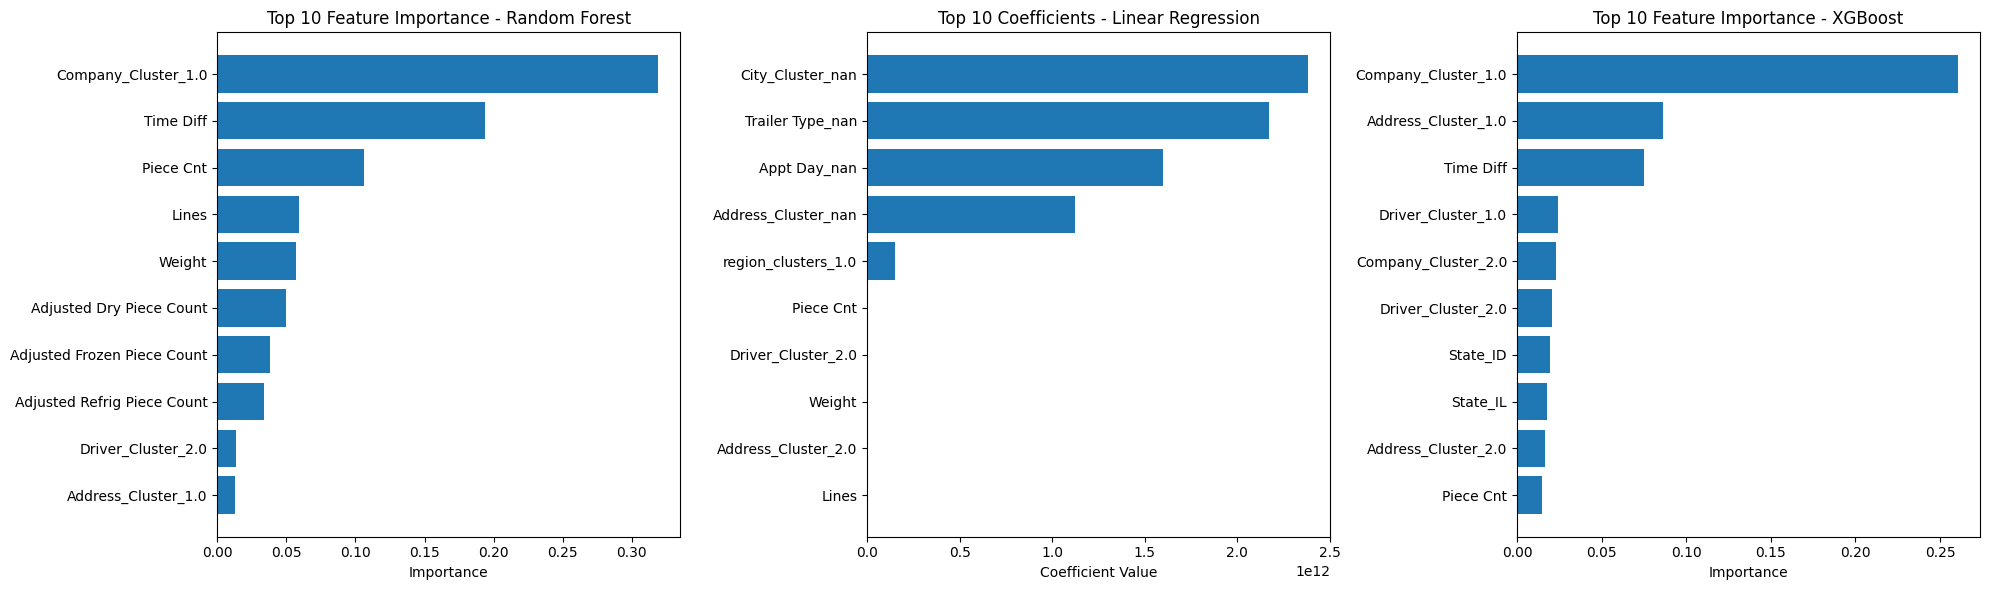

In [32]:
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': random_forest_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False).head(10)

# Linear Regression Coefficients
linear_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Linear_Coefficient': linear_model.coef_
}).sort_values(by='Linear_Coefficient', ascending=False).head(10)

# XGB Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values(by='XGB_Importance', ascending=False).head(10)

# Display the top 10 features for each model
print("   Top 10 Features by Random Forest Importance:")
print(rf_importance)
print("   Top 10 Features by Linear Regression Coefficients:")
print(linear_coefficients)
print("   Top 10 Features by XGB Importance:")
print(xgb_importance)

# Plotting each model's top 10 influential features in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Random Forest Plot
axes[0].barh(rf_importance['Feature'], rf_importance['RF_Importance'])
axes[0].set_xlabel("Importance")
axes[0].set_title("Top 10 Feature Importance - Random Forest")
axes[0].invert_yaxis()

# Linear Regression Plot
axes[1].barh(linear_coefficients['Feature'], linear_coefficients['Linear_Coefficient'])
axes[1].set_xlabel("Coefficient Value")
axes[1].set_title("Top 10 Coefficients - Linear Regression")
axes[1].invert_yaxis()

# XGB Plot
axes[2].barh(xgb_importance['Feature'], xgb_importance['XGB_Importance'])
axes[2].set_xlabel("Importance")
axes[2].set_title("Top 10 Feature Importance - XGBoost")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 定义需要进行对数变换的数值变量
numeric_to_log = ['Time Diff', 'Piece Cnt', 'Lines','Adjusted Refrig Piece Count']

# 对指定变量进行对数变换
for col in numeric_to_log:
    constant_shift = abs(merged_df_inner_3[col].min()) + 1  # 确保所有值为正
    merged_df_inner_3[col] = np.log1p(merged_df_inner_3[col] + constant_shift)

# 对目标变量进行对数变换
constant_shift_y = abs(merged_df_inner_3['Dock Time Converted'].min()) + 1
merged_df_inner_3['Dock Time Converted'] = np.log1p(merged_df_inner_3['Dock Time Converted'] + constant_shift_y)

# 分离特征 (X) 和目标变量 (y)
X = merged_df_inner_3.drop(columns=['Dock Time Converted','Routing Region','Driver Region','Driver','Company', 'Address', 'City','Region'])  # 特征
y = merged_df_inner_3['Dock Time Converted']  # 目标

# 训练测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义模型评估函数
def evaluate_model(model, X_test, y_test, constant_shift_y):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log) - constant_shift_y
    y_test_original = np.expm1(y_test) - constant_shift_y

    # 计算 RMSE 和 R²
    rmse = mean_squared_error(y_test_original, y_pred, squared=False)
    r2 = r2_score(y_test_original, y_pred)
    
    # 计算调整后的 R²
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    print(f"{model.__class__.__name__} - RMSE: {rmse:.2f}, R²: {r2:.2f}, Adjusted R²: {adjusted_r2:.2f}")
    return rmse, r2, adjusted_r2

# 初始化模型
linear_model = LinearRegression()
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# 训练并评估每个模型
print("Model Evaluation Results with Log-Transformation:")
linear_model.fit(X_train, y_train)
evaluate_model(linear_model, X_test, y_test, constant_shift_y)

random_forest_model.fit(X_train, y_train)
evaluate_model(random_forest_model, X_test, y_test, constant_shift_y)

xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, constant_shift_y)


Model Evaluation Results with Log-Transformation:
LinearRegression - RMSE: 2.68, R²: 0.29, Adjusted R²: 0.29
RandomForestRegressor - RMSE: 2.37, R²: 0.45, Adjusted R²: 0.44
XGBRegressor - RMSE: 2.33, R²: 0.46, Adjusted R²: 0.46


(2.3344958589504206, 0.46182440766176136, 0.4594506718457244)

   Top 10 Features by Random Forest Importance:
                        Feature  RF_Importance
22          Address_Cluster_1.0       0.328093
2                     Piece Cnt       0.132855
1                        Weight       0.075850
3                         Lines       0.072412
5      Adjusted Dry Piece Count       0.058917
4                     Time Diff       0.051986
7   Adjusted Frozen Piece Count       0.051301
6   Adjusted Refrig Piece Count       0.044983
19          Company_Cluster_1.0       0.020251
0                          Stop       0.016575
   Top 10 Features by Linear Regression Coefficients:
                Feature  Linear_Coefficient
23  Address_Cluster_2.0            1.040128
13   Driver_Cluster_1.0            0.832891
20  Company_Cluster_2.0            0.733085
14   Driver_Cluster_2.0            0.108825
50             State_KS            0.107080
84             State_WY            0.090935
74             State_SC            0.076249
43             State_DE      

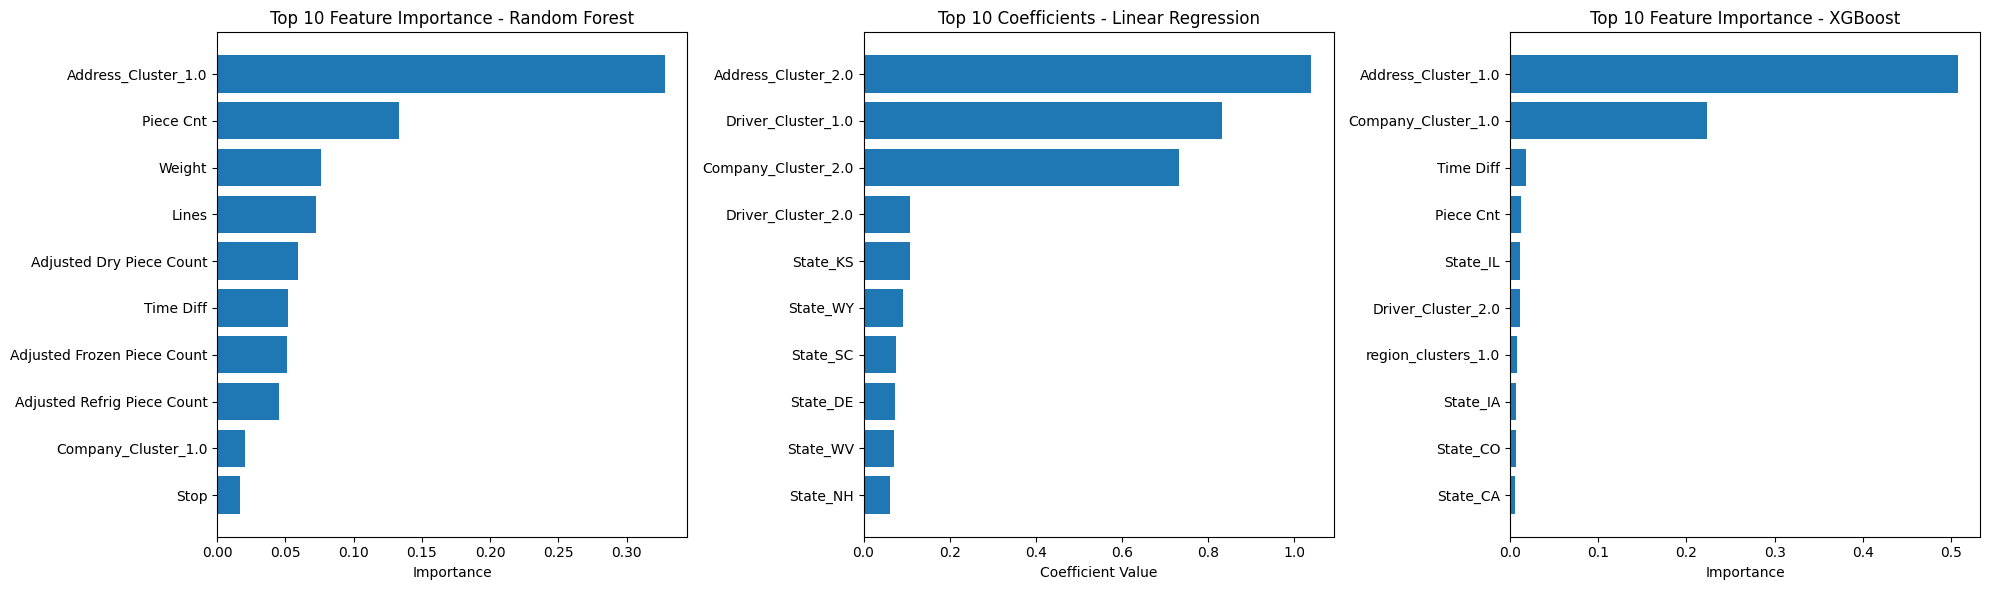

In [34]:
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': random_forest_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False).head(10)

# Linear Regression Coefficients
linear_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Linear_Coefficient': linear_model.coef_
}).sort_values(by='Linear_Coefficient', ascending=False).head(10)

# XGB Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'XGB_Importance': xgb_model.feature_importances_
}).sort_values(by='XGB_Importance', ascending=False).head(10)

# Display the top 10 features for each model
print("   Top 10 Features by Random Forest Importance:")
print(rf_importance)
print("   Top 10 Features by Linear Regression Coefficients:")
print(linear_coefficients)
print("   Top 10 Features by XGB Importance:")
print(xgb_importance)

# Plotting each model's top 10 influential features in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Random Forest Plot
axes[0].barh(rf_importance['Feature'], rf_importance['RF_Importance'])
axes[0].set_xlabel("Importance")
axes[0].set_title("Top 10 Feature Importance - Random Forest")
axes[0].invert_yaxis()

# Linear Regression Plot
axes[1].barh(linear_coefficients['Feature'], linear_coefficients['Linear_Coefficient'])
axes[1].set_xlabel("Coefficient Value")
axes[1].set_title("Top 10 Coefficients - Linear Regression")
axes[1].invert_yaxis()

# XGB Plot
axes[2].barh(xgb_importance['Feature'], xgb_importance['XGB_Importance'])
axes[2].set_xlabel("Importance")
axes[2].set_title("Top 10 Feature Importance - XGBoost")
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()
